In [44]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.metrics import TrueNegatives, TruePositives, FalseNegatives, FalsePositives, F1Score
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

# 데이터셋 생성

In [45]:
import os

X = np.empty((2000, 100, 100, 3))
Y = np.empty((2000,))

target = 'Bicycle'

folders = os.listdir('./images')
folders.remove(target)
folders.remove('Other')

files = os.listdir(f'./images/{target}')
for i in range(1000):
    x = cv2.imread(f"./images/{target}/{files[i]}")
    X[i] = cv2.resize(x, (100, 100))
    Y[i] = 1

files = os.listdir('./images/Other')
for i in range(300):
    x = cv2.imread(f"./images/Other/{files[i]}")
    X[i+1000] = cv2.resize(x, (100, 100))
    Y[i+1000] = 0

for f in range(7):
    files = os.listdir(f'./images/{folders[f]}')
    for i in range(100):
        x = cv2.imread(f"./images/{folders[f]}/{files[i]}")
        X[1300+f*100+i] = cv2.resize(x, (100, 100))
        Y[1300+f*100+i] = 0

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)

In [47]:
print(X_train.shape)
print(X_test.shape)
print( y_train.shape)
print(y_test.shape)

(1500, 100, 100, 3)
(500, 100, 100, 3)
(1500,)
(500,)


# 모델 생성

In [48]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(100, 100, 3)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(256, (3,3), activation='relu'))
model.add(Conv2D(256, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [49]:
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=[
        'accuracy',
        F1Score(), 
        TruePositives(name='TP'),
        TrueNegatives(name='TN'),
        FalsePositives(name='FP'),
        FalseNegatives(name='FN'),
    ],
)

In [50]:
modelpath=f"./models/{target.lower()}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

In [51]:
history = model.fit(X_train, y_train, validation_split=0.25, epochs=30, batch_size=100, verbose='auto', callbacks=[early_stopping_callback,checkpointer])

Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 2.9311 - accuracy: 0.5013 - f1_score: 0.6559 - TP: 225.0000 - TN: 339.0000 - FP: 237.0000 - FN: 324.0000
Epoch 1: val_loss improved from inf to 0.69442, saving model to ./models\bicycle.hdf5


c:\ProgramData\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 39s 3s/step - loss: 2.9311 - accuracy: 0.5013 - f1_score: 0.6559 - TP: 225.0000 - TN: 339.0000 - FP: 237.0000 - FN: 324.0000 - val_loss: 0.6944 - val_accuracy: 0.4747 - val_f1_score: 0.6888 - val_TP: 0.0000e+00 - val_TN: 178.0000 - val_FP: 0.0000e+00 - val_FN: 197.0000
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.6884 - accuracy: 0.5182 - f1_score: 0.6559 - TP: 92.0000 - TN: 491.0000 - FP: 85.0000 - FN: 457.0000
Epoch 2: val_loss improved from 0.69442 to 0.68434, saving model to ./models\bicycle.hdf5
12/12 [==============================] - 33s 3s/step - loss: 0.6884 - accuracy: 0.5182 - f1_score: 0.6559 - TP: 92.0000 - TN: 491.0000 - FP: 85.0000 - FN: 457.0000 - val_loss: 0.6843 - val_accuracy: 0.7067 - val_f1_score: 0.6888 - val_TP: 167.0000 - val_TN: 98.0000 - val_FP: 80.0000 - val_FN: 30.0000
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.6399 - accuracy: 0.6062 - f1_score: 0.6559 - TP: 201.000

In [52]:
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

16/16 [==============================] - 4s 221ms/step - loss: 0.5131 - accuracy: 0.7880 - f1_score: 0.6737 - TP: 222.0000 - TN: 172.0000 - FP: 74.0000 - FN: 32.0000


[0.5131399631500244,
 0.7879999876022339,
 array([0.6737401], dtype=float32),
 222.0,
 172.0,
 74.0,
 32.0]

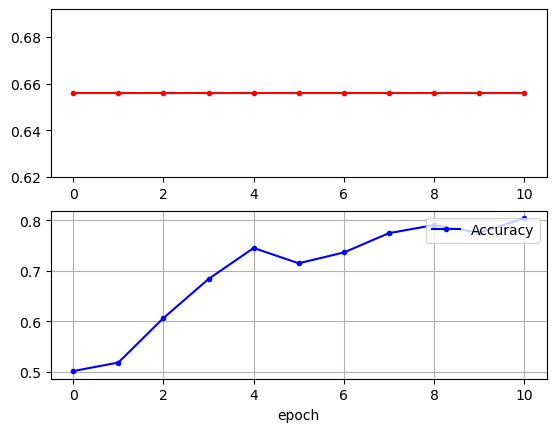

In [53]:
f1_score = history.history['f1_score']
accuracy = history.history['accuracy']

x_len = np.arange(len(f1_score))
plt.subplot(211)
plt.plot(x_len, f1_score, marker='.', c="red", label='F1 Score')
plt.subplot(212)
plt.plot(x_len, accuracy, marker='.', c="blue", label='Accuracy')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('')
plt.show()

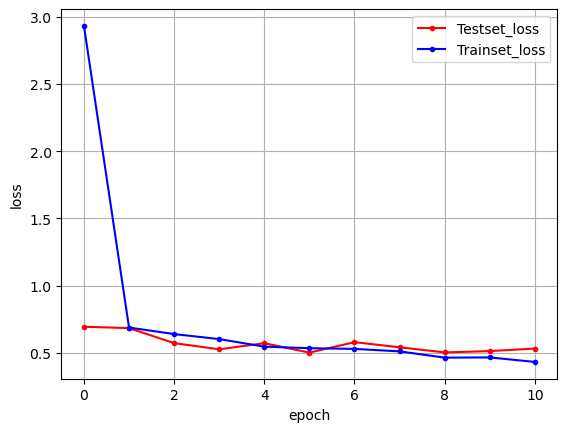

In [54]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

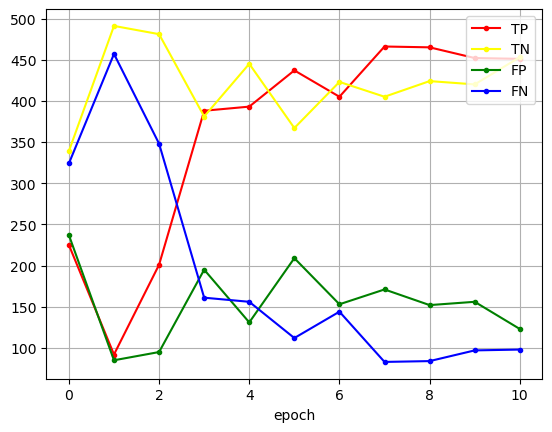

In [55]:
TP = history.history['TP']
TN = history.history['TN']
FP = history.history['FP']
FN = history.history['FN']

x_len = np.arange(len(TP))
plt.plot(x_len, TP, marker='.', c="red", label='TP')
plt.plot(x_len, TN, marker='.', c="yellow", label='TN')
plt.plot(x_len, FP, marker='.', c="green", label='FP')
plt.plot(x_len, FN, marker='.', c="blue", label='FN')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.show()

In [56]:
model.save(f"./models/{target.lower()}.h5")